In [1]:
TRAIN_MODEL = True
OUTPUT_PNG  = False
VISUALIZE   = True
USE_KNN     = True
USE_NAIVE   = False
V_WIDTH     = 200
BATCH_SIZE  = 128

In [2]:
import torch
import warnings

warnings.filterwarnings("ignore")
DEVICE = torch.device('cuda')

In [3]:
import numpy as np
import torch 
import random

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(880301)

In [4]:
import os

def path_join(arr):
    r = arr[0]
    for i in range(1, len(arr)):
        r = os.path.join(r, arr[i])
    return r

In [5]:
if OUTPUT_PNG:
    from PIL import Image
    import numpy as np

    train = np.load('train.npy', allow_pickle=True)
    for idx, img in enumerate(train):
        img_buf = np.uint8((img + 1) / 2 * 255)
        fig = Image.fromarray(img_buf)
        fig.save(path_join(['images', 'train', f'{idx}.png']))

    test = np.load('test.npy', allow_pickle=True)
    for idx, img in enumerate(test):
        img_buf = np.uint8((img + 1) / 2 * 255)
        fig = Image.fromarray(img_buf)
        fig.save(path_join(['images', 'test', f'{idx}.png']))

In [6]:
# from https://stackoverflow.com/a/47298639/4275047
def blur(a):
    kernel = np.array([[1.0,2.0,1.0], [2.0,4.0,2.0], [1.0,2.0,1.0]])
    kernel = kernel / np.sum(kernel)
    arraylist = []
    for y in range(3):
        temparray = np.copy(a)
        temparray = np.roll(temparray, y - 1, axis=0)
        for x in range(3):
            temparray_X = np.copy(temparray)
            temparray_X = np.roll(temparray_X, x - 1, axis=1)*kernel[y,x]
            arraylist.append(temparray_X)

    arraylist = np.array(arraylist)
    arraylist_sum = np.sum(arraylist, axis=0)
    return arraylist_sum

In [7]:
from torch import nn
from torch.autograd import Variable

class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 32 * 32 * 3
            ), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
fcn_autoencoder()

class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.BatchNorm2d(3),
            nn.ReLU(),
        )
    def encode(self, x):
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)
    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

<IPython.core.display.Javascript object>


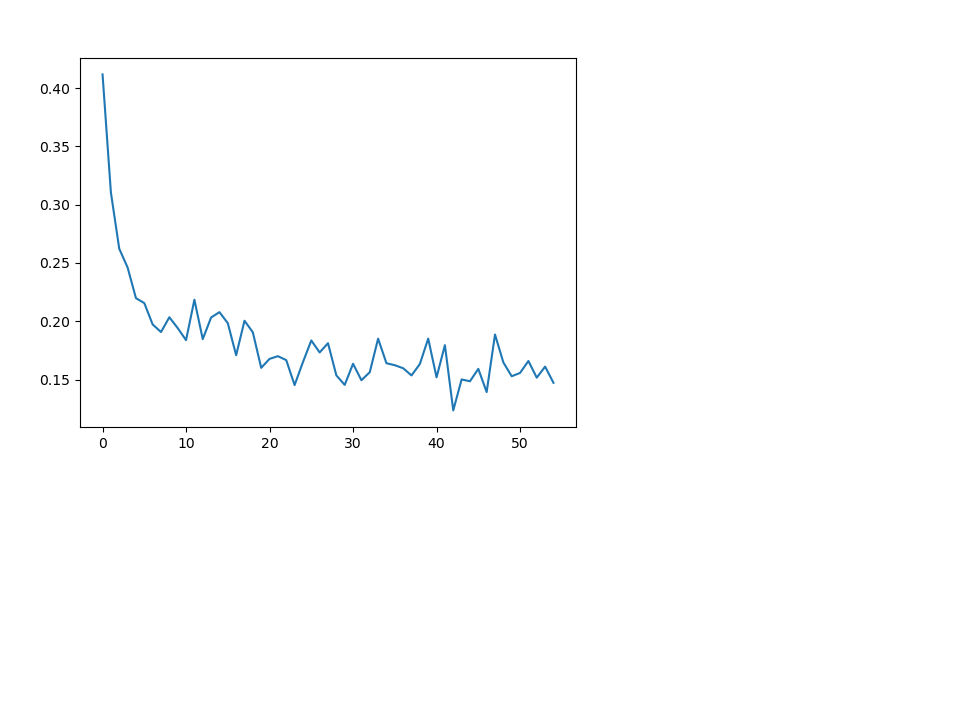

In [8]:
if VISUALIZE:
    %matplotlib notebook
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1)
    plt.ion()
    fig.show()
    
    def update_line(new_data):
        if not hasattr(update_line, "xs"):
            update_line.xs = []
        if not hasattr(update_line, "ys"):
            update_line.ys = []
        ax.clear()
        if len(update_line.xs) == V_WIDTH:
            update_line.xs = update_line.xs[1:]
        if len(update_line.ys) == V_WIDTH:
            update_line.ys = update_line.ys[1:]
        update_line.xs.append(new_data[0])
        update_line.ys.append(new_data[1])
        ax.plot(update_line.xs, update_line.ys)
        fig.canvas.draw()

In [9]:
if TRAIN_MODEL:
    from torch.utils.data import DataLoader, RandomSampler, TensorDataset, ConcatDataset
    import numpy as np
    import time

    num_epochs = 55
    learning_rate = 1e-5

    train = np.load('train.npy', allow_pickle=True)
    x = train
        
    data = torch.tensor(x, dtype=torch.float)
    train_dataset = TensorDataset(data)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler,
                                  batch_size=BATCH_SIZE,
                                  num_workers=(8 if os.name=='posix' else 0))


    model = conv_autoencoder().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate
    )
    
    best_loss = np.inf
    model.train()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        for data in train_dataloader:
            img = data[0].transpose(3, 1).cuda()
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ===================save====================
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model, 'best_model.pt')
        # ===================log========================
        update_line((epoch, loss.item()))
        print('epoch [{}/{}], loss:{:.4f} {:2.2f} sec(s)'
              .format(epoch + 1, num_epochs, loss.item(), time.time() - epoch_start_time))


    plt.close()

epoch [1/55], loss:0.4117 10.23 sec(s)
epoch [2/55], loss:0.3104 9.44 sec(s)
epoch [3/55], loss:0.2622 9.81 sec(s)
epoch [4/55], loss:0.2461 12.99 sec(s)
epoch [5/55], loss:0.2198 13.03 sec(s)
epoch [6/55], loss:0.2156 13.20 sec(s)
epoch [7/55], loss:0.1973 13.09 sec(s)
epoch [8/55], loss:0.1908 13.04 sec(s)
epoch [9/55], loss:0.2035 13.19 sec(s)
epoch [10/55], loss:0.1942 13.29 sec(s)
epoch [11/55], loss:0.1838 13.27 sec(s)
epoch [12/55], loss:0.2185 13.17 sec(s)
epoch [13/55], loss:0.1847 13.37 sec(s)
epoch [14/55], loss:0.2032 13.40 sec(s)
epoch [15/55], loss:0.2078 13.11 sec(s)
epoch [16/55], loss:0.1984 13.25 sec(s)
epoch [17/55], loss:0.1709 13.36 sec(s)
epoch [18/55], loss:0.2005 13.25 sec(s)
epoch [19/55], loss:0.1905 13.34 sec(s)
epoch [20/55], loss:0.1601 13.39 sec(s)
epoch [21/55], loss:0.1678 13.46 sec(s)
epoch [22/55], loss:0.1701 13.30 sec(s)
epoch [23/55], loss:0.1667 13.42 sec(s)
epoch [24/55], loss:0.1453 13.35 sec(s)
epoch [25/55], loss:0.1650 16.97 sec(s)
epoch [26/5

In [10]:
if USE_NAIVE:
    from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
    import numpy as np
    
    test = np.load('test.npy', allow_pickle=True)
    y = test
    
    data = torch.tensor(y, dtype=torch.float)
    test_dataset = TensorDataset(data)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler,
                                 batch_size=BATCH_SIZE, 
                                 num_workers=(16 if os.name=='posix' else 0))

    model = torch.load('best_model.pt').to(DEVICE)

    model.eval()
    reconstructed = []
    with torch.no_grad():
        for data in test_dataloader:
            output = model(data[0].transpose(3, 1).to(DEVICE))
            reconstructed.append(output.reshape(len(output), -1).cpu().detach().numpy())

    reconstructed = np.concatenate(reconstructed, axis=0)
    y_code = reconstructed
    y_cluster = np.zeros(len(y_code))
    
    anomality = np.sqrt(np.sum(np.square(reconstructed - y.reshape(len(y), -1)).reshape(len(y), -1), axis=1))
    y_pred = anomality
    with open('prediction_best.csv', 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(y_pred)):
            f.write('{},{}\n'.format(i+1, y_pred[i]))

In [11]:
if USE_KNN:
    from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
    from sklearn.cluster import MiniBatchKMeans
    from sklearn.metrics import f1_score, pairwise_distances, roc_auc_score
    from scipy.cluster.vq import vq, kmeans
    import numpy as np

    test = np.load('test.npy', allow_pickle=True)
    y = test
    
    data = torch.tensor(y, dtype=torch.float)
    test_dataset = TensorDataset(data)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler,
                                 batch_size=BATCH_SIZE, 
                                 num_workers=(16 if os.name=='posix' else 0))
    
    
    model = torch.load('best_model.pt').to(DEVICE)

    model.eval()
    y_code, reconstructed = [], []
    for i, data in enumerate(test_dataloader): 
        img = data[0].transpose(3, 1).cuda()
        output = model(img).transpose(3, 1)
        code = model.encode(img)
        y_code.append(code.detach().cpu().numpy())
        reconstructed.append(output.detach().cpu().numpy())

    y_code = np.concatenate(y_code, axis=0)
    y_code = y_code.reshape(len(y_code), -1)
    
    print(hash(str(y_code)))
    
    reconstructed = np.concatenate(reconstructed, axis=0)
    reconstructed = reconstructed.reshape(len(reconstructed), -1)
    
    kmeans = MiniBatchKMeans(n_clusters=6, batch_size=100).fit(y_code)
    y_cluster = kmeans.predict(y_code)
    y_dist = np.sum(np.square(kmeans.cluster_centers_[y_cluster] - y_code), axis=1)
    y_pred = y_dist


    with open('prediction_best.csv', 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(y_pred)):
            f.write('{},{}\n'.format(i+1, y_pred[i]))

4658637122986838368


[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 10000 samples in 7.982s...
[t-SNE] Computed neighbors for 10000 samples in 192.385s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.953092
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.951103
[t-SNE] KL divergence after 500 iterations: 1.873969


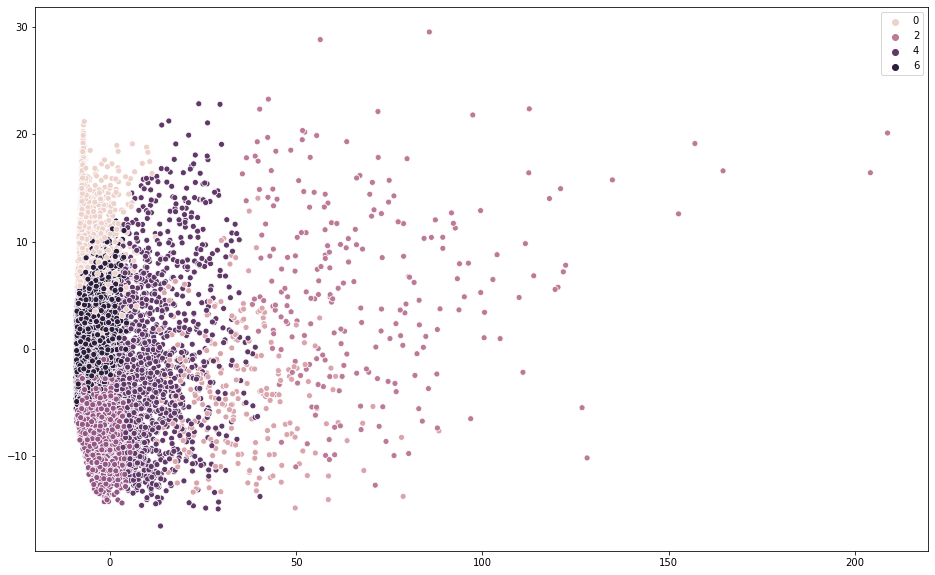

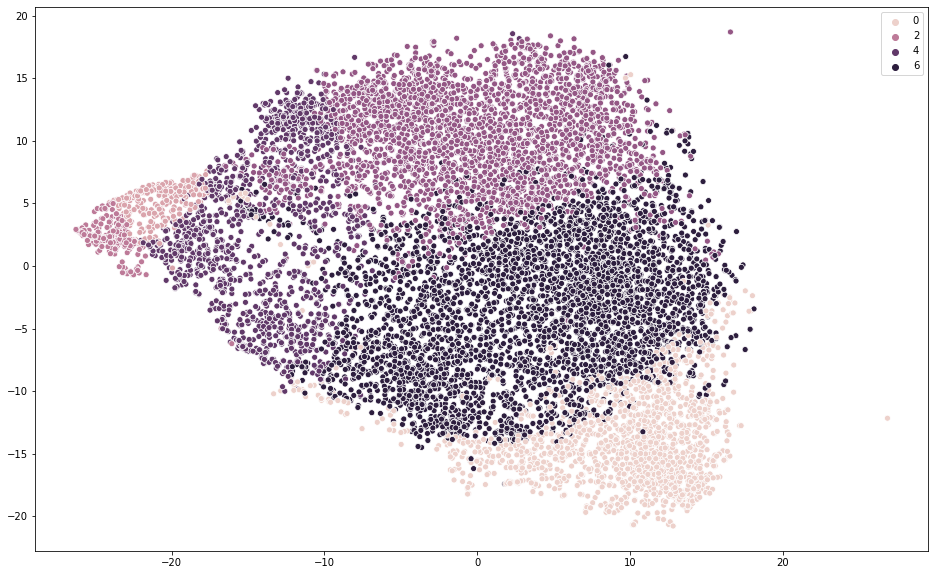

In [12]:
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

y_cluster = list(map(str, y_cluster))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(y_code)
pca_result = pca_result.transpose()

plt.figure(figsize=(16,10))
sns.scatterplot(pca_result[0], pca_result[1], y_cluster)


tsne = TSNE(n_components=2, verbose=1, perplexity=150, n_iter=500, random_state=7122)
tsne_results = tsne.fit_transform(y_code)
tsne_results = tsne_results.transpose()

plt.figure(figsize=(16,10))
sns.scatterplot(tsne_results[0], tsne_results[1], y_cluster)

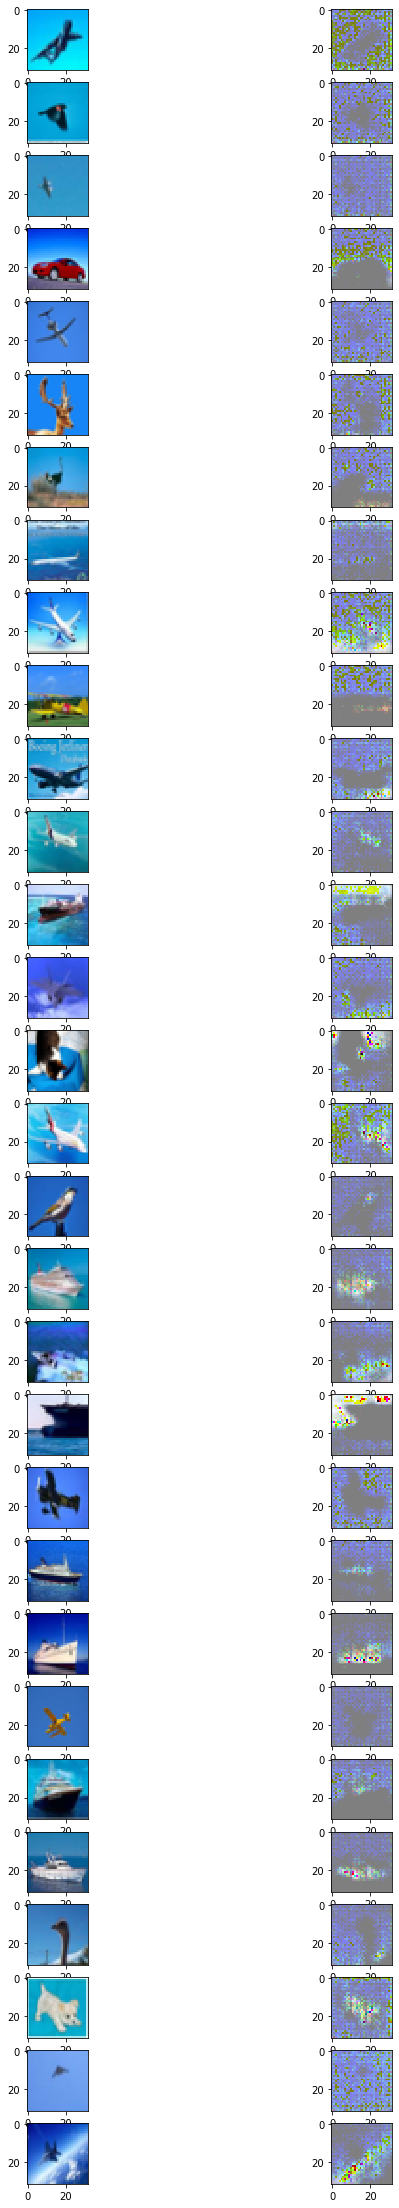

In [13]:
import numpy as np
import matplotlib.pyplot as plt

sorted_idx = y_pred.argsort()

fig, axes = plt.subplots(30,2, figsize=(10, 40))

for i in range(30):
    axes[i,0].imshow(np.uint8((y[sorted_idx[-i - 1]].reshape(32, 32, 3) + 1)/2*255))
    axes[i,1].imshow(np.uint8((reconstructed[sorted_idx[-i - 1]].reshape((32,32,3)) + 1)/2*255))
plt.show()
plt.close()